# PTN Template
This notebook serves as a template for single dataset PTN experiments  
It can be run on its own by setting STANDALONE to True (do a find for "STANDALONE" to see where)  
But it is intended to be executed as part of a *papermill.py script. See any of the   
experimentes with a papermill script to get started with that workflow.  

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

    
import os, json, sys, time, random
import numpy as np
import torch
from torch.optim import Adam
from  easydict import EasyDict
import matplotlib.pyplot as plt

from steves_models.steves_ptn import Steves_Prototypical_Network

from steves_utils.lazy_iterable_wrapper import Lazy_Iterable_Wrapper
from steves_utils.iterable_aggregator import Iterable_Aggregator
from steves_utils.ptn_train_eval_test_jig import  PTN_Train_Eval_Test_Jig
from steves_utils.torch_sequential_builder import build_sequential
from steves_utils.torch_utils import get_dataset_metrics, ptn_confusion_by_domain_over_dataloader
from steves_utils.utils_v2 import (per_domain_accuracy_from_confusion, get_datasets_base_path)
from steves_utils.PTN.utils import independent_accuracy_assesment

from steves_utils.stratified_dataset.episodic_accessor import Episodic_Accessor_Factory

from steves_utils.ptn_do_report import (
    get_loss_curve,
    get_results_table,
    get_parameters_table,
    get_domain_accuracies,
)

from steves_utils.transforms import get_chained_transform

# Required Parameters
These are allowed parameters, not defaults
Each of these values need to be present in the injected parameters (the notebook will raise an exception if they are not present)

Papermill uses the cell tag "parameters" to inject the real parameters below this cell.
Enable tags to see what I mean

In [2]:
required_parameters = {
    "experiment_name",
    "lr",
    "device",
    "seed",
    "dataset_seed",
    "labels_source",
    "labels_target",
    "domains_source",
    "domains_target",
    "num_examples_per_domain_per_label_source",
    "num_examples_per_domain_per_label_target",
    "n_shot",
    "n_way",
    "n_query",
    "train_k_factor",
    "val_k_factor",
    "test_k_factor",
    "n_epoch",
    "patience",
    "criteria_for_best",
    "x_transforms_source",
    "x_transforms_target",
    "episode_transforms_source",
    "episode_transforms_target",
    "pickle_name",
    "x_net",
    "NUM_LOGS_PER_EPOCH",
    "BEST_MODEL_PATH",
    "torch_default_dtype"
}

In [3]:


standalone_parameters = {}
standalone_parameters["experiment_name"] = "STANDALONE PTN"
standalone_parameters["lr"] = 0.0001
standalone_parameters["device"] = "cuda"

standalone_parameters["seed"] = 1337
standalone_parameters["dataset_seed"] = 1337


standalone_parameters["num_examples_per_domain_per_label_source"]=100
standalone_parameters["num_examples_per_domain_per_label_target"]=100

standalone_parameters["n_shot"] = 3
standalone_parameters["n_query"]  = 2
standalone_parameters["train_k_factor"] = 1
standalone_parameters["val_k_factor"] = 2
standalone_parameters["test_k_factor"] = 2


standalone_parameters["n_epoch"] = 100

standalone_parameters["patience"] = 10
standalone_parameters["criteria_for_best"] = "target_accuracy"

standalone_parameters["x_transforms_source"] = ["unit_power"]
standalone_parameters["x_transforms_target"] = ["unit_power"]
standalone_parameters["episode_transforms_source"] = []
standalone_parameters["episode_transforms_target"] = []

standalone_parameters["torch_default_dtype"] = "torch.float32" 



standalone_parameters["x_net"] =     [
    {"class": "nnReshape", "kargs": {"shape":[-1, 1, 2, 256]}},
    {"class": "Conv2d", "kargs": { "in_channels":1, "out_channels":256, "kernel_size":(1,7), "bias":False, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":256}},

    {"class": "Conv2d", "kargs": { "in_channels":256, "out_channels":80, "kernel_size":(2,7), "bias":True, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":80}},
    {"class": "Flatten", "kargs": {}},

    {"class": "Linear", "kargs": {"in_features": 80*256, "out_features": 256}}, # 80 units per IQ pair
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm1d", "kargs": {"num_features":256}},

    {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
]

# Parameters relevant to results
# These parameters will basically never need to change
standalone_parameters["NUM_LOGS_PER_EPOCH"] = 10
standalone_parameters["BEST_MODEL_PATH"] = "./best_model.pth"

# uncomment for CORES dataset
from steves_utils.CORES.utils import (
    ALL_NODES,
    ALL_NODES_MINIMUM_1000_EXAMPLES,
    ALL_DAYS
)


standalone_parameters["labels_source"] = ALL_NODES
standalone_parameters["labels_target"] = ALL_NODES

standalone_parameters["domains_source"] = [1]
standalone_parameters["domains_target"] = [2,3,4,5]

standalone_parameters["pickle_name"] = "cores.stratified_ds.2022A.pkl"


# Uncomment these for ORACLE dataset
# from steves_utils.ORACLE.utils_v2 import (
#     ALL_DISTANCES_FEET,
#     ALL_RUNS,
#     ALL_SERIAL_NUMBERS,
# )
# standalone_parameters["labels_source"] = ALL_SERIAL_NUMBERS
# standalone_parameters["labels_target"] = ALL_SERIAL_NUMBERS
# standalone_parameters["domains_source"] = [8,20, 38,50]
# standalone_parameters["domains_target"] = [14, 26, 32, 44, 56]
# standalone_parameters["pickle_name"] = "oracle.frame_indexed.stratified_ds.2022A.pkl"
# standalone_parameters["num_examples_per_domain_per_label_source"]=1000
# standalone_parameters["num_examples_per_domain_per_label_target"]=1000

# Uncomment these for Metahan dataset
# standalone_parameters["labels_source"] = list(range(19))
# standalone_parameters["labels_target"] = list(range(19))
# standalone_parameters["domains_source"] = [0]
# standalone_parameters["domains_target"] = [1]
# standalone_parameters["pickle_name"] = "metehan.stratified_ds.2022A.pkl"
# standalone_parameters["n_way"]  = len(standalone_parameters["labels_source"])
# standalone_parameters["num_examples_per_domain_per_label_source"]=200
# standalone_parameters["num_examples_per_domain_per_label_target"]=100


standalone_parameters["n_way"]  = len(standalone_parameters["labels_source"])

In [4]:
# Parameters
parameters = {
    "experiment_name": "tuned_1v2:wisig",
    "device": "cuda",
    "lr": 0.0001,
    "labels_source": [
        "1-10",
        "1-12",
        "1-14",
        "1-16",
        "1-18",
        "1-19",
        "1-8",
        "10-11",
        "10-17",
        "10-4",
        "10-7",
        "11-1",
        "11-10",
        "11-19",
        "11-20",
        "11-4",
        "11-7",
        "12-19",
        "12-20",
        "12-7",
        "13-14",
        "13-18",
        "13-19",
        "13-20",
        "13-3",
        "13-7",
        "14-10",
        "14-11",
        "14-12",
        "14-13",
        "14-14",
        "14-19",
        "14-20",
        "14-7",
        "14-8",
        "14-9",
        "15-1",
        "15-19",
        "15-6",
        "16-1",
        "16-16",
        "16-19",
        "16-20",
        "17-10",
        "17-11",
        "18-1",
        "18-10",
        "18-11",
        "18-12",
        "18-13",
        "18-14",
        "18-15",
        "18-16",
        "18-17",
        "18-19",
        "18-2",
        "18-20",
        "18-4",
        "18-5",
        "18-7",
        "18-8",
        "18-9",
        "19-1",
        "19-10",
        "19-11",
        "19-12",
        "19-13",
        "19-14",
        "19-15",
        "19-19",
        "19-2",
        "19-20",
        "19-3",
        "19-4",
        "19-6",
        "19-7",
        "19-8",
        "19-9",
        "2-1",
        "2-13",
        "2-15",
        "2-3",
        "2-4",
        "2-5",
        "2-6",
        "2-7",
        "2-8",
        "20-1",
        "20-12",
        "20-14",
        "20-15",
        "20-16",
        "20-18",
        "20-19",
        "20-20",
        "20-3",
        "20-4",
        "20-5",
        "20-7",
        "20-8",
        "3-1",
        "3-13",
        "3-18",
        "3-2",
        "3-8",
        "4-1",
        "4-10",
        "4-11",
        "5-1",
        "5-5",
        "6-1",
        "6-15",
        "6-6",
        "7-10",
        "7-11",
        "7-12",
        "7-13",
        "7-14",
        "7-7",
        "7-8",
        "7-9",
        "8-1",
        "8-13",
        "8-14",
        "8-18",
        "8-20",
        "8-3",
        "8-8",
        "9-1",
        "9-7",
    ],
    "labels_target": [
        "1-10",
        "1-12",
        "1-14",
        "1-16",
        "1-18",
        "1-19",
        "1-8",
        "10-11",
        "10-17",
        "10-4",
        "10-7",
        "11-1",
        "11-10",
        "11-19",
        "11-20",
        "11-4",
        "11-7",
        "12-19",
        "12-20",
        "12-7",
        "13-14",
        "13-18",
        "13-19",
        "13-20",
        "13-3",
        "13-7",
        "14-10",
        "14-11",
        "14-12",
        "14-13",
        "14-14",
        "14-19",
        "14-20",
        "14-7",
        "14-8",
        "14-9",
        "15-1",
        "15-19",
        "15-6",
        "16-1",
        "16-16",
        "16-19",
        "16-20",
        "17-10",
        "17-11",
        "18-1",
        "18-10",
        "18-11",
        "18-12",
        "18-13",
        "18-14",
        "18-15",
        "18-16",
        "18-17",
        "18-19",
        "18-2",
        "18-20",
        "18-4",
        "18-5",
        "18-7",
        "18-8",
        "18-9",
        "19-1",
        "19-10",
        "19-11",
        "19-12",
        "19-13",
        "19-14",
        "19-15",
        "19-19",
        "19-2",
        "19-20",
        "19-3",
        "19-4",
        "19-6",
        "19-7",
        "19-8",
        "19-9",
        "2-1",
        "2-13",
        "2-15",
        "2-3",
        "2-4",
        "2-5",
        "2-6",
        "2-7",
        "2-8",
        "20-1",
        "20-12",
        "20-14",
        "20-15",
        "20-16",
        "20-18",
        "20-19",
        "20-20",
        "20-3",
        "20-4",
        "20-5",
        "20-7",
        "20-8",
        "3-1",
        "3-13",
        "3-18",
        "3-2",
        "3-8",
        "4-1",
        "4-10",
        "4-11",
        "5-1",
        "5-5",
        "6-1",
        "6-15",
        "6-6",
        "7-10",
        "7-11",
        "7-12",
        "7-13",
        "7-14",
        "7-7",
        "7-8",
        "7-9",
        "8-1",
        "8-13",
        "8-14",
        "8-18",
        "8-20",
        "8-3",
        "8-8",
        "9-1",
        "9-7",
    ],
    "episode_transforms_source": [],
    "episode_transforms_target": [],
    "domains_source": [3],
    "domains_target": [1, 2, 4],
    "num_examples_per_domain_per_label_source": -1,
    "num_examples_per_domain_per_label_target": -1,
    "n_shot": 3,
    "n_way": 130,
    "n_query": 2,
    "train_k_factor": 3,
    "val_k_factor": 2,
    "test_k_factor": 2,
    "torch_default_dtype": "torch.float32",
    "n_epoch": 50,
    "patience": 3,
    "criteria_for_best": "target_accuracy",
    "x_net": [
        {"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 1,
                "out_channels": 256,
                "kernel_size": [1, 7],
                "bias": False,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 256}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 256,
                "out_channels": 80,
                "kernel_size": [2, 7],
                "bias": True,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 80}},
        {"class": "Flatten", "kargs": {}},
        {"class": "Linear", "kargs": {"in_features": 20480, "out_features": 256}},
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm1d", "kargs": {"num_features": 256}},
        {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
    ],
    "NUM_LOGS_PER_EPOCH": 10,
    "BEST_MODEL_PATH": "./best_model.pth",
    "pickle_name": "wisig.node3-19.stratified_ds.2022A.pkl",
    "x_transforms_source": ["unit_power"],
    "x_transforms_target": ["unit_power"],
    "dataset_seed": 420,
    "seed": 420,
}


In [5]:
# Set this to True if you want to run this template directly
STANDALONE = False
if STANDALONE:
    print("parameters not injected, running with standalone_parameters")
    parameters = standalone_parameters

if not 'parameters' in locals() and not 'parameters' in globals():
    raise Exception("Parameter injection failed")

#Use an easy dict for all the parameters
p = EasyDict(parameters)

supplied_keys = set(p.keys())

if  supplied_keys != required_parameters:
    print("Parameters are incorrect")
    if len(supplied_keys - required_parameters)>0: print("Shouldn't have:", str(supplied_keys - required_parameters))
    if len(required_parameters - supplied_keys)>0: print("Need to have:", str(required_parameters - supplied_keys))
    raise RuntimeError("Parameters are incorrect")



In [6]:
###################################
# Set the RNGs and make it all deterministic
###################################
np.random.seed(p.seed)
random.seed(p.seed)
torch.manual_seed(p.seed)

torch.use_deterministic_algorithms(True) 

In [7]:
###########################################
# The stratified datasets honor this
###########################################
torch.set_default_dtype(eval(p.torch_default_dtype))

In [8]:
###################################
# Build the network(s)
# Note: It's critical to do this AFTER setting the RNG
# (This is due to the randomized initial weights)
###################################
x_net = build_sequential(p.x_net)

In [9]:
start_time_secs = time.time()

In [10]:
###################################
# Build the dataset
###################################

if p.x_transforms_source == []: x_transform_source = None
else: x_transform_source = get_chained_transform(p.x_transforms_source) 

if p.x_transforms_target == []: x_transform_target = None
else: x_transform_target = get_chained_transform(p.x_transforms_target)

if p.episode_transforms_source == []: episode_transform_source = None
else: raise Exception("episode_transform_source not implemented")

if p.episode_transforms_target == []: episode_transform_target = None
else: raise Exception("episode_transform_target not implemented")


eaf_source = Episodic_Accessor_Factory(
    labels=p.labels_source,
    domains=p.domains_source,
    num_examples_per_domain_per_label=p.num_examples_per_domain_per_label_source,
    iterator_seed=p.seed,
    dataset_seed=p.dataset_seed,
    n_shot=p.n_shot,
    n_way=p.n_way,
    n_query=p.n_query,
    train_val_test_k_factors=(p.train_k_factor,p.val_k_factor,p.test_k_factor),
    pickle_path=os.path.join(get_datasets_base_path(), p.pickle_name),
    x_transform_func=x_transform_source,
    example_transform_func=episode_transform_source,
    
)
train_original_source, val_original_source, test_original_source = eaf_source.get_train(), eaf_source.get_val(), eaf_source.get_test()


eaf_target = Episodic_Accessor_Factory(
    labels=p.labels_target,
    domains=p.domains_target,
    num_examples_per_domain_per_label=p.num_examples_per_domain_per_label_target,
    iterator_seed=p.seed,
    dataset_seed=p.dataset_seed,
    n_shot=p.n_shot,
    n_way=p.n_way,
    n_query=p.n_query,
    train_val_test_k_factors=(p.train_k_factor,p.val_k_factor,p.test_k_factor),
    pickle_path=os.path.join(get_datasets_base_path(), p.pickle_name),
    x_transform_func=x_transform_target,
    example_transform_func=episode_transform_target,
)
train_original_target, val_original_target, test_original_target = eaf_target.get_train(), eaf_target.get_val(), eaf_target.get_test()


transform_lambda = lambda ex: ex[1] # Original is (<domain>, <episode>) so we strip down to episode only

train_processed_source = Lazy_Iterable_Wrapper(train_original_source, transform_lambda)
val_processed_source   = Lazy_Iterable_Wrapper(val_original_source, transform_lambda)
test_processed_source  = Lazy_Iterable_Wrapper(test_original_source, transform_lambda)

train_processed_target = Lazy_Iterable_Wrapper(train_original_target, transform_lambda)
val_processed_target   = Lazy_Iterable_Wrapper(val_original_target, transform_lambda)
test_processed_target  = Lazy_Iterable_Wrapper(test_original_target, transform_lambda)

datasets = EasyDict({
    "source": {
        "original": {"train":train_original_source, "val":val_original_source, "test":test_original_source},
        "processed": {"train":train_processed_source, "val":val_processed_source, "test":test_processed_source}
    },
    "target": {
        "original": {"train":train_original_target, "val":val_original_target, "test":test_original_target},
        "processed": {"train":train_processed_target, "val":val_processed_target, "test":test_processed_target}
    },
})

In [11]:
# Some quick unit tests on the data
from steves_utils.transforms import get_average_power, get_average_magnitude

q_x, q_y, s_x, s_y, truth = next(iter(train_processed_source))

assert q_x.dtype == eval(p.torch_default_dtype)
assert s_x.dtype == eval(p.torch_default_dtype)

print("Visually inspect these to see if they line up with expected values given the transforms")
print('x_transforms_source', p.x_transforms_source)
print('x_transforms_target', p.x_transforms_target)
print("Average magnitude, source:", get_average_magnitude(q_x[0].numpy()))
print("Average power, source:", get_average_power(q_x[0].numpy()))

q_x, q_y, s_x, s_y, truth = next(iter(train_processed_target))
print("Average magnitude, target:", get_average_magnitude(q_x[0].numpy()))
print("Average power, target:", get_average_power(q_x[0].numpy()))


Visually inspect these to see if they line up with expected values given the transforms
x_transforms_source ['unit_power']
x_transforms_target ['unit_power']
Average magnitude, source: 0.9105453
Average power, source: 1.0


Average magnitude, target: 0.9017792
Average power, target: 1.0000001


In [12]:
###################################
# Build the model
###################################
model = Steves_Prototypical_Network(x_net, device=p.device, x_shape=(2,256))
optimizer = Adam(params=model.parameters(), lr=p.lr)

(2, 256)


In [13]:
###################################
# train
###################################
jig = PTN_Train_Eval_Test_Jig(model, p.BEST_MODEL_PATH, p.device)

jig.train(
    train_iterable=datasets.source.processed.train,
    source_val_iterable=datasets.source.processed.val,
    target_val_iterable=datasets.target.processed.val,
    num_epochs=p.n_epoch,
    num_logs_per_epoch=p.NUM_LOGS_PER_EPOCH,
    patience=p.patience,
    optimizer=optimizer,
    criteria_for_best=p.criteria_for_best,
)

epoch: 1, [batch: 1 / 45], examples_per_second: 1964.4213, train_label_loss: 4.7173, 


epoch: 1, [batch: 5 / 45], examples_per_second: 3918.8848, train_label_loss: 4.1388, 


epoch: 1, [batch: 9 / 45], examples_per_second: 4011.4601, train_label_loss: 3.5130, 


epoch: 1, [batch: 14 / 45], examples_per_second: 4014.9033, train_label_loss: 2.8194, 


epoch: 1, [batch: 18 / 45], examples_per_second: 4008.1147, train_label_loss: 2.4913, 


epoch: 1, [batch: 23 / 45], examples_per_second: 3951.4457, train_label_loss: 2.1202, 


epoch: 1, [batch: 27 / 45], examples_per_second: 4062.4554, train_label_loss: 2.0040, 


epoch: 1, [batch: 31 / 45], examples_per_second: 4062.1861, train_label_loss: 1.6705, 


epoch: 1, [batch: 36 / 45], examples_per_second: 4098.1993, train_label_loss: 1.6641, 


epoch: 1, [batch: 40 / 45], examples_per_second: 4154.8410, train_label_loss: 1.4227, 


epoch: 1, source_val_acc_label: 0.7474, target_val_acc_label: 0.7370, source_val_label_loss: 1.3955, target_val_label_loss: 1.5201, 


New best


epoch: 2, [batch: 1 / 45], examples_per_second: 495.9125, train_label_loss: 1.2377, 


epoch: 2, [batch: 5 / 45], examples_per_second: 3982.7103, train_label_loss: 1.2022, 


epoch: 2, [batch: 9 / 45], examples_per_second: 4085.6447, train_label_loss: 1.2699, 


epoch: 2, [batch: 14 / 45], examples_per_second: 4077.2896, train_label_loss: 1.2314, 


epoch: 2, [batch: 18 / 45], examples_per_second: 4087.8685, train_label_loss: 0.9630, 


epoch: 2, [batch: 23 / 45], examples_per_second: 4037.3038, train_label_loss: 0.9938, 


epoch: 2, [batch: 27 / 45], examples_per_second: 4131.7618, train_label_loss: 1.0178, 


epoch: 2, [batch: 31 / 45], examples_per_second: 4136.9892, train_label_loss: 0.9551, 


epoch: 2, [batch: 36 / 45], examples_per_second: 4165.6686, train_label_loss: 1.0645, 


epoch: 2, [batch: 40 / 45], examples_per_second: 4232.7701, train_label_loss: 0.9100, 


epoch: 2, source_val_acc_label: 0.8269, target_val_acc_label: 0.7964, source_val_label_loss: 0.9238, target_val_label_loss: 1.1481, 


New best


epoch: 3, [batch: 1 / 45], examples_per_second: 491.6664, train_label_loss: 0.8560, 


epoch: 3, [batch: 5 / 45], examples_per_second: 3988.5836, train_label_loss: 0.8462, 


epoch: 3, [batch: 9 / 45], examples_per_second: 4089.1668, train_label_loss: 0.7542, 


epoch: 3, [batch: 14 / 45], examples_per_second: 4092.8172, train_label_loss: 0.6808, 


epoch: 3, [batch: 18 / 45], examples_per_second: 4101.6848, train_label_loss: 0.5865, 


epoch: 3, [batch: 23 / 45], examples_per_second: 4046.5838, train_label_loss: 0.6682, 


epoch: 3, [batch: 27 / 45], examples_per_second: 4139.4122, train_label_loss: 0.7736, 


epoch: 3, [batch: 31 / 45], examples_per_second: 4148.6150, train_label_loss: 0.8005, 


epoch: 3, [batch: 36 / 45], examples_per_second: 4176.1627, train_label_loss: 0.5440, 


epoch: 3, [batch: 40 / 45], examples_per_second: 4227.7061, train_label_loss: 0.6175, 


epoch: 3, source_val_acc_label: 0.8718, target_val_acc_label: 0.8124, source_val_label_loss: 0.6730, target_val_label_loss: 0.9842, 


New best


epoch: 4, [batch: 1 / 45], examples_per_second: 492.0869, train_label_loss: 0.4331, 


epoch: 4, [batch: 5 / 45], examples_per_second: 3970.3300, train_label_loss: 0.5907, 


epoch: 4, [batch: 9 / 45], examples_per_second: 4085.4105, train_label_loss: 0.4312, 


epoch: 4, [batch: 14 / 45], examples_per_second: 4088.9696, train_label_loss: 0.7580, 


epoch: 4, [batch: 18 / 45], examples_per_second: 4082.6361, train_label_loss: 0.4938, 


epoch: 4, [batch: 23 / 45], examples_per_second: 4026.6373, train_label_loss: 0.4633, 


epoch: 4, [batch: 27 / 45], examples_per_second: 4131.2422, train_label_loss: 0.3138, 


epoch: 4, [batch: 31 / 45], examples_per_second: 4134.6740, train_label_loss: 0.4229, 


epoch: 4, [batch: 36 / 45], examples_per_second: 4169.2972, train_label_loss: 0.3627, 


epoch: 4, [batch: 40 / 45], examples_per_second: 4235.3165, train_label_loss: 0.3830, 


epoch: 4, source_val_acc_label: 0.9051, target_val_acc_label: 0.8348, source_val_label_loss: 0.5191, target_val_label_loss: 0.9119, 


New best


epoch: 5, [batch: 1 / 45], examples_per_second: 489.4911, train_label_loss: 0.2911, 


epoch: 5, [batch: 5 / 45], examples_per_second: 3974.6250, train_label_loss: 0.4083, 


epoch: 5, [batch: 9 / 45], examples_per_second: 4072.5869, train_label_loss: 0.4360, 


epoch: 5, [batch: 14 / 45], examples_per_second: 4087.3953, train_label_loss: 0.4189, 


epoch: 5, [batch: 18 / 45], examples_per_second: 4087.3813, train_label_loss: 0.3175, 


epoch: 5, [batch: 23 / 45], examples_per_second: 4021.2148, train_label_loss: 0.5118, 


epoch: 5, [batch: 27 / 45], examples_per_second: 4138.1132, train_label_loss: 0.3385, 


epoch: 5, [batch: 31 / 45], examples_per_second: 4132.7749, train_label_loss: 0.3331, 


epoch: 5, [batch: 36 / 45], examples_per_second: 4174.5347, train_label_loss: 0.4029, 


epoch: 5, [batch: 40 / 45], examples_per_second: 4233.4718, train_label_loss: 0.3360, 


epoch: 5, source_val_acc_label: 0.9237, target_val_acc_label: 0.8423, source_val_label_loss: 0.4262, target_val_label_loss: 0.8479, 


New best


epoch: 6, [batch: 1 / 45], examples_per_second: 489.0355, train_label_loss: 0.3879, 


epoch: 6, [batch: 5 / 45], examples_per_second: 3976.8397, train_label_loss: 0.1556, 


epoch: 6, [batch: 9 / 45], examples_per_second: 4084.8902, train_label_loss: 0.1591, 


epoch: 6, [batch: 14 / 45], examples_per_second: 4085.6667, train_label_loss: 0.4455, 


epoch: 6, [batch: 18 / 45], examples_per_second: 4080.7065, train_label_loss: 0.1081, 


epoch: 6, [batch: 23 / 45], examples_per_second: 4024.2171, train_label_loss: 0.2577, 


epoch: 6, [batch: 27 / 45], examples_per_second: 4132.8485, train_label_loss: 0.3609, 


epoch: 6, [batch: 31 / 45], examples_per_second: 4139.6181, train_label_loss: 0.2356, 


epoch: 6, [batch: 36 / 45], examples_per_second: 4172.0586, train_label_loss: 0.4335, 


epoch: 6, [batch: 40 / 45], examples_per_second: 4227.0556, train_label_loss: 0.2821, 


epoch: 6, source_val_acc_label: 0.9365, target_val_acc_label: 0.8588, source_val_label_loss: 0.3628, target_val_label_loss: 0.7894, 


New best


epoch: 7, [batch: 1 / 45], examples_per_second: 488.7389, train_label_loss: 0.4095, 


epoch: 7, [batch: 5 / 45], examples_per_second: 3970.7623, train_label_loss: 0.2100, 


epoch: 7, [batch: 9 / 45], examples_per_second: 4071.9923, train_label_loss: 0.2637, 


epoch: 7, [batch: 14 / 45], examples_per_second: 4078.0458, train_label_loss: 0.3048, 


epoch: 7, [batch: 18 / 45], examples_per_second: 4059.5972, train_label_loss: 0.1895, 


epoch: 7, [batch: 23 / 45], examples_per_second: 4019.4031, train_label_loss: 0.2303, 


epoch: 7, [batch: 27 / 45], examples_per_second: 4121.0959, train_label_loss: 0.3161, 


epoch: 7, [batch: 31 / 45], examples_per_second: 4124.0820, train_label_loss: 0.2537, 


epoch: 7, [batch: 36 / 45], examples_per_second: 4162.6067, train_label_loss: 0.2990, 


epoch: 7, [batch: 40 / 45], examples_per_second: 4223.8466, train_label_loss: 0.2215, 


epoch: 7, source_val_acc_label: 0.9423, target_val_acc_label: 0.8635, source_val_label_loss: 0.3428, target_val_label_loss: 0.7679, 


New best


epoch: 8, [batch: 1 / 45], examples_per_second: 490.0361, train_label_loss: 0.2969, 


epoch: 8, [batch: 5 / 45], examples_per_second: 3970.6640, train_label_loss: 0.1756, 


epoch: 8, [batch: 9 / 45], examples_per_second: 4082.0003, train_label_loss: 0.2115, 


epoch: 8, [batch: 14 / 45], examples_per_second: 4074.3477, train_label_loss: 0.1743, 


epoch: 8, [batch: 18 / 45], examples_per_second: 4069.3362, train_label_loss: 0.2679, 


epoch: 8, [batch: 23 / 45], examples_per_second: 4016.0282, train_label_loss: 0.1519, 


epoch: 8, [batch: 27 / 45], examples_per_second: 4126.6398, train_label_loss: 0.1719, 


epoch: 8, [batch: 31 / 45], examples_per_second: 4121.6379, train_label_loss: 0.1122, 


epoch: 8, [batch: 36 / 45], examples_per_second: 4165.1887, train_label_loss: 0.1172, 


epoch: 8, [batch: 40 / 45], examples_per_second: 4224.1885, train_label_loss: 0.1516, 


epoch: 8, source_val_acc_label: 0.9487, target_val_acc_label: 0.8613, source_val_label_loss: 0.3218, target_val_label_loss: 0.7541, 


epoch: 9, [batch: 1 / 45], examples_per_second: 499.5447, train_label_loss: 0.1297, 


epoch: 9, [batch: 5 / 45], examples_per_second: 3968.8851, train_label_loss: 0.1185, 


epoch: 9, [batch: 9 / 45], examples_per_second: 4071.3979, train_label_loss: 0.2044, 


epoch: 9, [batch: 14 / 45], examples_per_second: 4071.6144, train_label_loss: 0.2596, 


epoch: 9, [batch: 18 / 45], examples_per_second: 4054.0661, train_label_loss: 0.1013, 


epoch: 9, [batch: 23 / 45], examples_per_second: 4019.3379, train_label_loss: 0.2483, 


epoch: 9, [batch: 27 / 45], examples_per_second: 4124.9915, train_label_loss: 0.2084, 


epoch: 9, [batch: 31 / 45], examples_per_second: 4126.1995, train_label_loss: 0.2443, 


epoch: 9, [batch: 36 / 45], examples_per_second: 4167.9395, train_label_loss: 0.2422, 


epoch: 9, [batch: 40 / 45], examples_per_second: 4222.6117, train_label_loss: 0.1149, 


epoch: 9, source_val_acc_label: 0.9487, target_val_acc_label: 0.8652, source_val_label_loss: 0.3071, target_val_label_loss: 0.7374, 


New best


epoch: 10, [batch: 1 / 45], examples_per_second: 487.8049, train_label_loss: 0.1663, 


epoch: 10, [batch: 5 / 45], examples_per_second: 3983.2485, train_label_loss: 0.1267, 


epoch: 10, [batch: 9 / 45], examples_per_second: 4072.3390, train_label_loss: 0.2263, 


epoch: 10, [batch: 14 / 45], examples_per_second: 4076.9323, train_label_loss: 0.2072, 


epoch: 10, [batch: 18 / 45], examples_per_second: 4076.2937, train_label_loss: 0.1405, 


epoch: 10, [batch: 23 / 45], examples_per_second: 4020.6657, train_label_loss: 0.1922, 


epoch: 10, [batch: 27 / 45], examples_per_second: 4120.4886, train_label_loss: 0.2908, 


epoch: 10, [batch: 31 / 45], examples_per_second: 4131.0841, train_label_loss: 0.1518, 


epoch: 10, [batch: 36 / 45], examples_per_second: 4170.4707, train_label_loss: 0.2096, 


epoch: 10, [batch: 40 / 45], examples_per_second: 4216.1241, train_label_loss: 0.0640, 


epoch: 10, source_val_acc_label: 0.9538, target_val_acc_label: 0.8716, source_val_label_loss: 0.2978, target_val_label_loss: 0.7245, 


New best


epoch: 11, [batch: 1 / 45], examples_per_second: 485.2245, train_label_loss: 0.0795, 


epoch: 11, [batch: 5 / 45], examples_per_second: 3976.0843, train_label_loss: 0.1988, 


epoch: 11, [batch: 9 / 45], examples_per_second: 4066.3091, train_label_loss: 0.1083, 


epoch: 11, [batch: 14 / 45], examples_per_second: 4065.0977, train_label_loss: 0.1578, 


epoch: 11, [batch: 18 / 45], examples_per_second: 4063.7831, train_label_loss: 0.1752, 


epoch: 11, [batch: 23 / 45], examples_per_second: 4010.5245, train_label_loss: 0.0945, 


epoch: 11, [batch: 27 / 45], examples_per_second: 4120.2893, train_label_loss: 0.0654, 


epoch: 11, [batch: 31 / 45], examples_per_second: 4119.5656, train_label_loss: 0.1666, 


epoch: 11, [batch: 36 / 45], examples_per_second: 4161.3106, train_label_loss: 0.1725, 


epoch: 11, [batch: 40 / 45], examples_per_second: 4215.9187, train_label_loss: 0.0828, 


epoch: 11, source_val_acc_label: 0.9532, target_val_acc_label: 0.8665, source_val_label_loss: 0.2928, target_val_label_loss: 0.7442, 


epoch: 12, [batch: 1 / 45], examples_per_second: 499.9799, train_label_loss: 0.1218, 


epoch: 12, [batch: 5 / 45], examples_per_second: 3970.0742, train_label_loss: 0.0976, 


epoch: 12, [batch: 9 / 45], examples_per_second: 4064.2344, train_label_loss: 0.1493, 


epoch: 12, [batch: 14 / 45], examples_per_second: 4063.1045, train_label_loss: 0.1908, 


epoch: 12, [batch: 18 / 45], examples_per_second: 4073.7310, train_label_loss: 0.1569, 


epoch: 12, [batch: 23 / 45], examples_per_second: 4012.9247, train_label_loss: 0.1337, 


epoch: 12, [batch: 27 / 45], examples_per_second: 4121.2034, train_label_loss: 0.2079, 


epoch: 12, [batch: 31 / 45], examples_per_second: 4109.0197, train_label_loss: 0.1393, 


epoch: 12, [batch: 36 / 45], examples_per_second: 4160.0444, train_label_loss: 0.1489, 


epoch: 12, [batch: 40 / 45], examples_per_second: 4218.7092, train_label_loss: 0.2085, 


epoch: 12, source_val_acc_label: 0.9506, target_val_acc_label: 0.8744, source_val_label_loss: 0.2891, target_val_label_loss: 0.7047, 


New best


epoch: 13, [batch: 1 / 45], examples_per_second: 488.4977, train_label_loss: 0.1131, 


epoch: 13, [batch: 5 / 45], examples_per_second: 3962.8910, train_label_loss: 0.1229, 


epoch: 13, [batch: 9 / 45], examples_per_second: 4069.2269, train_label_loss: 0.0590, 


epoch: 13, [batch: 14 / 45], examples_per_second: 4066.3613, train_label_loss: 0.1765, 


epoch: 13, [batch: 18 / 45], examples_per_second: 4066.8914, train_label_loss: 0.1392, 


epoch: 13, [batch: 23 / 45], examples_per_second: 4016.0566, train_label_loss: 0.2339, 


epoch: 13, [batch: 27 / 45], examples_per_second: 4122.1926, train_label_loss: 0.1724, 


epoch: 13, [batch: 31 / 45], examples_per_second: 4125.5439, train_label_loss: 0.1075, 


epoch: 13, [batch: 36 / 45], examples_per_second: 4150.8857, train_label_loss: 0.1324, 


epoch: 13, [batch: 40 / 45], examples_per_second: 4211.4576, train_label_loss: 0.2078, 


epoch: 13, source_val_acc_label: 0.9519, target_val_acc_label: 0.8726, source_val_label_loss: 0.2930, target_val_label_loss: 0.7391, 


epoch: 14, [batch: 1 / 45], examples_per_second: 499.9091, train_label_loss: 0.0573, 


epoch: 14, [batch: 5 / 45], examples_per_second: 3959.7728, train_label_loss: 0.0701, 


epoch: 14, [batch: 9 / 45], examples_per_second: 4063.1593, train_label_loss: 0.2618, 


epoch: 14, [batch: 14 / 45], examples_per_second: 4064.0166, train_label_loss: 0.1319, 


epoch: 14, [batch: 18 / 45], examples_per_second: 4077.8409, train_label_loss: 0.1822, 


epoch: 14, [batch: 23 / 45], examples_per_second: 4020.9906, train_label_loss: 0.1205, 


epoch: 14, [batch: 27 / 45], examples_per_second: 4126.4837, train_label_loss: 0.0827, 


epoch: 14, [batch: 31 / 45], examples_per_second: 4119.7010, train_label_loss: 0.0732, 


epoch: 14, [batch: 36 / 45], examples_per_second: 4158.2361, train_label_loss: 0.1052, 


epoch: 14, [batch: 40 / 45], examples_per_second: 4212.0106, train_label_loss: 0.2109, 


epoch: 14, source_val_acc_label: 0.9526, target_val_acc_label: 0.8722, source_val_label_loss: 0.2884, target_val_label_loss: 0.7324, 


epoch: 15, [batch: 1 / 45], examples_per_second: 503.4325, train_label_loss: 0.1222, 


epoch: 15, [batch: 5 / 45], examples_per_second: 3942.2188, train_label_loss: 0.0861, 


epoch: 15, [batch: 9 / 45], examples_per_second: 4057.3014, train_label_loss: 0.1022, 


epoch: 15, [batch: 14 / 45], examples_per_second: 4050.7805, train_label_loss: 0.0434, 


epoch: 15, [batch: 18 / 45], examples_per_second: 4073.0524, train_label_loss: 0.1595, 


epoch: 15, [batch: 23 / 45], examples_per_second: 3983.0026, train_label_loss: 0.0594, 


epoch: 15, [batch: 27 / 45], examples_per_second: 4121.2252, train_label_loss: 0.1040, 


epoch: 15, [batch: 31 / 45], examples_per_second: 4110.6212, train_label_loss: 0.0678, 


epoch: 15, [batch: 36 / 45], examples_per_second: 4155.5829, train_label_loss: 0.0732, 


epoch: 15, [batch: 40 / 45], examples_per_second: 4220.0871, train_label_loss: 0.2297, 


epoch: 15, source_val_acc_label: 0.9494, target_val_acc_label: 0.8763, source_val_label_loss: 0.3020, target_val_label_loss: 0.7285, 


New best


epoch: 16, [batch: 1 / 45], examples_per_second: 486.1911, train_label_loss: 0.0862, 


epoch: 16, [batch: 5 / 45], examples_per_second: 3969.7476, train_label_loss: 0.0751, 


epoch: 16, [batch: 9 / 45], examples_per_second: 4065.4662, train_label_loss: 0.0864, 


epoch: 16, [batch: 14 / 45], examples_per_second: 4068.6831, train_label_loss: 0.1230, 


epoch: 16, [batch: 18 / 45], examples_per_second: 4080.0897, train_label_loss: 0.1654, 


epoch: 16, [batch: 23 / 45], examples_per_second: 4020.6562, train_label_loss: 0.1491, 


epoch: 16, [batch: 27 / 45], examples_per_second: 4125.8248, train_label_loss: 0.1652, 


epoch: 16, [batch: 31 / 45], examples_per_second: 4131.0278, train_label_loss: 0.0962, 


epoch: 16, [batch: 36 / 45], examples_per_second: 4157.6502, train_label_loss: 0.1483, 


epoch: 16, [batch: 40 / 45], examples_per_second: 4218.1544, train_label_loss: 0.1095, 


epoch: 16, source_val_acc_label: 0.9526, target_val_acc_label: 0.8778, source_val_label_loss: 0.2817, target_val_label_loss: 0.7129, 


New best


epoch: 17, [batch: 1 / 45], examples_per_second: 490.2702, train_label_loss: 0.1501, 


epoch: 17, [batch: 5 / 45], examples_per_second: 3962.5296, train_label_loss: 0.1384, 


epoch: 17, [batch: 9 / 45], examples_per_second: 4063.1472, train_label_loss: 0.0786, 


epoch: 17, [batch: 14 / 45], examples_per_second: 4078.3813, train_label_loss: 0.2090, 


epoch: 17, [batch: 18 / 45], examples_per_second: 4068.9050, train_label_loss: 0.1077, 


epoch: 17, [batch: 23 / 45], examples_per_second: 4016.3500, train_label_loss: 0.1863, 


epoch: 17, [batch: 27 / 45], examples_per_second: 4123.4052, train_label_loss: 0.0883, 


epoch: 17, [batch: 31 / 45], examples_per_second: 4122.6055, train_label_loss: 0.0536, 


epoch: 17, [batch: 36 / 45], examples_per_second: 4159.7702, train_label_loss: 0.0839, 


epoch: 17, [batch: 40 / 45], examples_per_second: 4215.3842, train_label_loss: 0.1469, 


epoch: 17, source_val_acc_label: 0.9532, target_val_acc_label: 0.8754, source_val_label_loss: 0.2840, target_val_label_loss: 0.7281, 


epoch: 18, [batch: 1 / 45], examples_per_second: 501.3545, train_label_loss: 0.0816, 


epoch: 18, [batch: 5 / 45], examples_per_second: 3956.8662, train_label_loss: 0.1280, 


epoch: 18, [batch: 9 / 45], examples_per_second: 4062.3268, train_label_loss: 0.1732, 


epoch: 18, [batch: 14 / 45], examples_per_second: 4067.7421, train_label_loss: 0.1179, 


epoch: 18, [batch: 18 / 45], examples_per_second: 4070.1169, train_label_loss: 0.0816, 


epoch: 18, [batch: 23 / 45], examples_per_second: 4008.5420, train_label_loss: 0.1853, 


epoch: 18, [batch: 27 / 45], examples_per_second: 4125.4299, train_label_loss: 0.1061, 


epoch: 18, [batch: 31 / 45], examples_per_second: 4126.9350, train_label_loss: 0.0774, 


epoch: 18, [batch: 36 / 45], examples_per_second: 4157.2419, train_label_loss: 0.1532, 


epoch: 18, [batch: 40 / 45], examples_per_second: 4210.7990, train_label_loss: 0.1160, 


epoch: 18, source_val_acc_label: 0.9532, target_val_acc_label: 0.8786, source_val_label_loss: 0.2888, target_val_label_loss: 0.7027, 


New best


epoch: 19, [batch: 1 / 45], examples_per_second: 486.5101, train_label_loss: 0.0623, 


epoch: 19, [batch: 5 / 45], examples_per_second: 3948.6537, train_label_loss: 0.1302, 


epoch: 19, [batch: 9 / 45], examples_per_second: 4055.5089, train_label_loss: 0.0842, 


epoch: 19, [batch: 14 / 45], examples_per_second: 4057.4651, train_label_loss: 0.1159, 


epoch: 19, [batch: 18 / 45], examples_per_second: 4060.3378, train_label_loss: 0.0567, 


epoch: 19, [batch: 23 / 45], examples_per_second: 4002.0563, train_label_loss: 0.0587, 


epoch: 19, [batch: 27 / 45], examples_per_second: 4109.2969, train_label_loss: 0.1214, 


epoch: 19, [batch: 31 / 45], examples_per_second: 4099.8020, train_label_loss: 0.0592, 


epoch: 19, [batch: 36 / 45], examples_per_second: 4152.5308, train_label_loss: 0.0183, 


epoch: 19, [batch: 40 / 45], examples_per_second: 4209.9196, train_label_loss: 0.1361, 


epoch: 19, source_val_acc_label: 0.9609, target_val_acc_label: 0.8786, source_val_label_loss: 0.2713, target_val_label_loss: 0.7219, 


epoch: 20, [batch: 1 / 45], examples_per_second: 500.7633, train_label_loss: 0.1129, 


epoch: 20, [batch: 5 / 45], examples_per_second: 3964.4570, train_label_loss: 0.1001, 


epoch: 20, [batch: 9 / 45], examples_per_second: 4058.2904, train_label_loss: 0.1050, 


epoch: 20, [batch: 14 / 45], examples_per_second: 4069.8833, train_label_loss: 0.1075, 


epoch: 20, [batch: 18 / 45], examples_per_second: 4063.8316, train_label_loss: 0.0627, 


epoch: 20, [batch: 23 / 45], examples_per_second: 4009.8638, train_label_loss: 0.1659, 


epoch: 20, [batch: 27 / 45], examples_per_second: 4114.0205, train_label_loss: 0.0721, 


epoch: 20, [batch: 31 / 45], examples_per_second: 4119.4551, train_label_loss: 0.1530, 


epoch: 20, [batch: 36 / 45], examples_per_second: 4155.4879, train_label_loss: 0.1314, 


epoch: 20, [batch: 40 / 45], examples_per_second: 4210.2641, train_label_loss: 0.0800, 


epoch: 20, source_val_acc_label: 0.9532, target_val_acc_label: 0.8782, source_val_label_loss: 0.2948, target_val_label_loss: 0.7287, 


epoch: 21, [batch: 1 / 45], examples_per_second: 500.0832, train_label_loss: 0.1796, 


epoch: 21, [batch: 5 / 45], examples_per_second: 3967.1222, train_label_loss: 0.0985, 


epoch: 21, [batch: 9 / 45], examples_per_second: 4073.8877, train_label_loss: 0.1092, 


epoch: 21, [batch: 14 / 45], examples_per_second: 4065.4396, train_label_loss: 0.0324, 


epoch: 21, [batch: 18 / 45], examples_per_second: 4068.5680, train_label_loss: 0.0663, 


epoch: 21, [batch: 23 / 45], examples_per_second: 4004.7923, train_label_loss: 0.0480, 


epoch: 21, [batch: 27 / 45], examples_per_second: 4123.3662, train_label_loss: 0.0480, 


epoch: 21, [batch: 31 / 45], examples_per_second: 4117.7658, train_label_loss: 0.0260, 


epoch: 21, [batch: 36 / 45], examples_per_second: 4163.0860, train_label_loss: 0.0485, 


epoch: 21, [batch: 40 / 45], examples_per_second: 4212.8844, train_label_loss: 0.0850, 


epoch: 21, source_val_acc_label: 0.9583, target_val_acc_label: 0.8831, source_val_label_loss: 0.2903, target_val_label_loss: 0.6902, 


New best


epoch: 22, [batch: 1 / 45], examples_per_second: 487.0572, train_label_loss: 0.0698, 


epoch: 22, [batch: 5 / 45], examples_per_second: 3969.0989, train_label_loss: 0.0235, 


epoch: 22, [batch: 9 / 45], examples_per_second: 4065.9680, train_label_loss: 0.0694, 


epoch: 22, [batch: 14 / 45], examples_per_second: 4056.3856, train_label_loss: 0.0239, 


epoch: 22, [batch: 18 / 45], examples_per_second: 4063.0457, train_label_loss: 0.0409, 


epoch: 22, [batch: 23 / 45], examples_per_second: 4013.0559, train_label_loss: 0.1079, 


epoch: 22, [batch: 27 / 45], examples_per_second: 4124.2426, train_label_loss: 0.0980, 


epoch: 22, [batch: 31 / 45], examples_per_second: 4132.3443, train_label_loss: 0.0379, 


epoch: 22, [batch: 36 / 45], examples_per_second: 4152.8825, train_label_loss: 0.0268, 


epoch: 22, [batch: 40 / 45], examples_per_second: 4215.9480, train_label_loss: 0.1218, 


epoch: 22, source_val_acc_label: 0.9564, target_val_acc_label: 0.8835, source_val_label_loss: 0.2825, target_val_label_loss: 0.6942, 


New best


epoch: 23, [batch: 1 / 45], examples_per_second: 487.7586, train_label_loss: 0.0516, 


epoch: 23, [batch: 5 / 45], examples_per_second: 3974.5569, train_label_loss: 0.0799, 


epoch: 23, [batch: 9 / 45], examples_per_second: 4060.1791, train_label_loss: 0.0482, 


epoch: 23, [batch: 14 / 45], examples_per_second: 4052.1845, train_label_loss: 0.0766, 


epoch: 23, [batch: 18 / 45], examples_per_second: 4063.2910, train_label_loss: 0.0156, 


epoch: 23, [batch: 23 / 45], examples_per_second: 4010.9222, train_label_loss: 0.0344, 


epoch: 23, [batch: 27 / 45], examples_per_second: 4111.8457, train_label_loss: 0.1419, 


epoch: 23, [batch: 31 / 45], examples_per_second: 4118.2401, train_label_loss: 0.0794, 


epoch: 23, [batch: 36 / 45], examples_per_second: 4154.4507, train_label_loss: 0.0917, 


epoch: 23, [batch: 40 / 45], examples_per_second: 4204.4124, train_label_loss: 0.0606, 


epoch: 23, source_val_acc_label: 0.9538, target_val_acc_label: 0.8844, source_val_label_loss: 0.2931, target_val_label_loss: 0.6965, 


New best


epoch: 24, [batch: 1 / 45], examples_per_second: 482.0631, train_label_loss: 0.0224, 


epoch: 24, [batch: 5 / 45], examples_per_second: 3954.2133, train_label_loss: 0.0528, 


epoch: 24, [batch: 9 / 45], examples_per_second: 4043.6126, train_label_loss: 0.0617, 


epoch: 24, [batch: 14 / 45], examples_per_second: 4055.6048, train_label_loss: 0.0986, 


epoch: 24, [batch: 18 / 45], examples_per_second: 4075.3127, train_label_loss: 0.1509, 


epoch: 24, [batch: 23 / 45], examples_per_second: 4021.8591, train_label_loss: 0.0602, 


epoch: 24, [batch: 27 / 45], examples_per_second: 4124.1771, train_label_loss: 0.0204, 


epoch: 24, [batch: 31 / 45], examples_per_second: 4118.4252, train_label_loss: 0.0451, 


epoch: 24, [batch: 36 / 45], examples_per_second: 4158.1181, train_label_loss: 0.1449, 


epoch: 24, [batch: 40 / 45], examples_per_second: 4210.5698, train_label_loss: 0.1472, 


epoch: 24, source_val_acc_label: 0.9583, target_val_acc_label: 0.8818, source_val_label_loss: 0.2867, target_val_label_loss: 0.7180, 


epoch: 25, [batch: 1 / 45], examples_per_second: 503.1499, train_label_loss: 0.0774, 


epoch: 25, [batch: 5 / 45], examples_per_second: 3973.1103, train_label_loss: 0.1181, 


epoch: 25, [batch: 9 / 45], examples_per_second: 4059.7030, train_label_loss: 0.1162, 


epoch: 25, [batch: 14 / 45], examples_per_second: 4065.0395, train_label_loss: 0.0583, 


epoch: 25, [batch: 18 / 45], examples_per_second: 4065.9665, train_label_loss: 0.0817, 


epoch: 25, [batch: 23 / 45], examples_per_second: 4016.0708, train_label_loss: 0.0437, 


epoch: 25, [batch: 27 / 45], examples_per_second: 4122.8830, train_label_loss: 0.0211, 


epoch: 25, [batch: 31 / 45], examples_per_second: 4102.9657, train_label_loss: 0.0933, 


epoch: 25, [batch: 36 / 45], examples_per_second: 4150.4156, train_label_loss: 0.0881, 


epoch: 25, [batch: 40 / 45], examples_per_second: 4214.6820, train_label_loss: 0.0598, 


epoch: 25, source_val_acc_label: 0.9596, target_val_acc_label: 0.8833, source_val_label_loss: 0.2850, target_val_label_loss: 0.7036, 


epoch: 26, [batch: 1 / 45], examples_per_second: 500.8410, train_label_loss: 0.0213, 


epoch: 26, [batch: 5 / 45], examples_per_second: 3976.0002, train_label_loss: 0.0325, 


epoch: 26, [batch: 9 / 45], examples_per_second: 4061.2587, train_label_loss: 0.1070, 


epoch: 26, [batch: 14 / 45], examples_per_second: 4073.6951, train_label_loss: 0.0764, 


epoch: 26, [batch: 18 / 45], examples_per_second: 4074.3748, train_label_loss: 0.0792, 


epoch: 26, [batch: 23 / 45], examples_per_second: 4023.2253, train_label_loss: 0.1472, 


epoch: 26, [batch: 27 / 45], examples_per_second: 4127.2676, train_label_loss: 0.1030, 


epoch: 26, [batch: 31 / 45], examples_per_second: 4134.6866, train_label_loss: 0.0544, 


epoch: 26, [batch: 36 / 45], examples_per_second: 4163.6277, train_label_loss: 0.0853, 


epoch: 26, [batch: 40 / 45], examples_per_second: 4214.6005, train_label_loss: 0.0600, 


epoch: 26, source_val_acc_label: 0.9583, target_val_acc_label: 0.8846, source_val_label_loss: 0.2895, target_val_label_loss: 0.6828, 


New best


epoch: 27, [batch: 1 / 45], examples_per_second: 485.3784, train_label_loss: 0.0790, 


epoch: 27, [batch: 5 / 45], examples_per_second: 3953.3331, train_label_loss: 0.1245, 


epoch: 27, [batch: 9 / 45], examples_per_second: 4061.8759, train_label_loss: 0.0481, 


epoch: 27, [batch: 14 / 45], examples_per_second: 4066.3770, train_label_loss: 0.0430, 


epoch: 27, [batch: 18 / 45], examples_per_second: 4055.4652, train_label_loss: 0.0341, 


epoch: 27, [batch: 23 / 45], examples_per_second: 4011.5796, train_label_loss: 0.0940, 


epoch: 27, [batch: 27 / 45], examples_per_second: 4121.2221, train_label_loss: 0.0096, 


epoch: 27, [batch: 31 / 45], examples_per_second: 4129.4353, train_label_loss: 0.1475, 


epoch: 27, [batch: 36 / 45], examples_per_second: 4152.8117, train_label_loss: 0.0524, 


epoch: 27, [batch: 40 / 45], examples_per_second: 4212.5687, train_label_loss: 0.0445, 


epoch: 27, source_val_acc_label: 0.9571, target_val_acc_label: 0.8806, source_val_label_loss: 0.2759, target_val_label_loss: 0.7026, 


epoch: 28, [batch: 1 / 45], examples_per_second: 502.9745, train_label_loss: 0.0597, 


epoch: 28, [batch: 5 / 45], examples_per_second: 3954.6105, train_label_loss: 0.0875, 


epoch: 28, [batch: 9 / 45], examples_per_second: 4039.4232, train_label_loss: 0.0171, 


epoch: 28, [batch: 14 / 45], examples_per_second: 4066.2400, train_label_loss: 0.0763, 


epoch: 28, [batch: 18 / 45], examples_per_second: 4075.7544, train_label_loss: 0.0650, 


epoch: 28, [batch: 23 / 45], examples_per_second: 4015.4639, train_label_loss: 0.0489, 


epoch: 28, [batch: 27 / 45], examples_per_second: 4117.5575, train_label_loss: 0.0246, 


epoch: 28, [batch: 31 / 45], examples_per_second: 4117.2637, train_label_loss: 0.0367, 


epoch: 28, [batch: 36 / 45], examples_per_second: 4147.8872, train_label_loss: 0.0461, 


epoch: 28, [batch: 40 / 45], examples_per_second: 4210.6023, train_label_loss: 0.0564, 


epoch: 28, source_val_acc_label: 0.9571, target_val_acc_label: 0.8842, source_val_label_loss: 0.3065, target_val_label_loss: 0.7088, 


epoch: 29, [batch: 1 / 45], examples_per_second: 499.1887, train_label_loss: 0.1021, 


epoch: 29, [batch: 5 / 45], examples_per_second: 3955.5816, train_label_loss: 0.0828, 


epoch: 29, [batch: 9 / 45], examples_per_second: 4053.6758, train_label_loss: 0.0846, 


epoch: 29, [batch: 14 / 45], examples_per_second: 4056.2058, train_label_loss: 0.0353, 


epoch: 29, [batch: 18 / 45], examples_per_second: 4038.8323, train_label_loss: 0.0684, 


epoch: 29, [batch: 23 / 45], examples_per_second: 4000.8981, train_label_loss: 0.1262, 


epoch: 29, [batch: 27 / 45], examples_per_second: 4116.3281, train_label_loss: 0.0872, 


epoch: 29, [batch: 31 / 45], examples_per_second: 4110.5298, train_label_loss: 0.1278, 


epoch: 29, [batch: 36 / 45], examples_per_second: 4139.6819, train_label_loss: 0.0295, 


epoch: 29, [batch: 40 / 45], examples_per_second: 4191.4683, train_label_loss: 0.1405, 


epoch: 29, source_val_acc_label: 0.9583, target_val_acc_label: 0.8806, source_val_label_loss: 0.2881, target_val_label_loss: 0.7010, 


epoch: 30, [batch: 1 / 45], examples_per_second: 500.8166, train_label_loss: 0.1074, 


epoch: 30, [batch: 5 / 45], examples_per_second: 3957.0026, train_label_loss: 0.0833, 


epoch: 30, [batch: 9 / 45], examples_per_second: 4046.2336, train_label_loss: 0.0666, 


epoch: 30, [batch: 14 / 45], examples_per_second: 4061.7243, train_label_loss: 0.0963, 


epoch: 30, [batch: 18 / 45], examples_per_second: 4051.6320, train_label_loss: 0.0835, 


epoch: 30, [batch: 23 / 45], examples_per_second: 4003.0999, train_label_loss: 0.0818, 


epoch: 30, [batch: 27 / 45], examples_per_second: 4104.9163, train_label_loss: 0.0740, 


epoch: 30, [batch: 31 / 45], examples_per_second: 4102.9981, train_label_loss: 0.1058, 


epoch: 30, [batch: 36 / 45], examples_per_second: 4143.6999, train_label_loss: 0.1115, 


epoch: 30, [batch: 40 / 45], examples_per_second: 4198.3392, train_label_loss: 0.1214, 


epoch: 30, source_val_acc_label: 0.9609, target_val_acc_label: 0.8857, source_val_label_loss: 0.2997, target_val_label_loss: 0.7058, 


New best


epoch: 31, [batch: 1 / 45], examples_per_second: 490.9732, train_label_loss: 0.0800, 


epoch: 31, [batch: 5 / 45], examples_per_second: 3959.6850, train_label_loss: 0.0364, 


epoch: 31, [batch: 9 / 45], examples_per_second: 4062.8111, train_label_loss: 0.0376, 


epoch: 31, [batch: 14 / 45], examples_per_second: 4077.2237, train_label_loss: 0.0114, 


epoch: 31, [batch: 18 / 45], examples_per_second: 4056.4034, train_label_loss: 0.0308, 


epoch: 31, [batch: 23 / 45], examples_per_second: 4011.7437, train_label_loss: 0.0488, 


epoch: 31, [batch: 27 / 45], examples_per_second: 4116.7989, train_label_loss: 0.0771, 


epoch: 31, [batch: 31 / 45], examples_per_second: 4117.8218, train_label_loss: 0.0344, 


epoch: 31, [batch: 36 / 45], examples_per_second: 4156.4205, train_label_loss: 0.0435, 


epoch: 31, [batch: 40 / 45], examples_per_second: 4217.2752, train_label_loss: 0.1066, 


epoch: 31, source_val_acc_label: 0.9635, target_val_acc_label: 0.8835, source_val_label_loss: 0.2815, target_val_label_loss: 0.6944, 


epoch: 32, [batch: 1 / 45], examples_per_second: 500.8143, train_label_loss: 0.0817, 


epoch: 32, [batch: 5 / 45], examples_per_second: 3965.8079, train_label_loss: 0.0389, 


epoch: 32, [batch: 9 / 45], examples_per_second: 4068.4329, train_label_loss: 0.0302, 


epoch: 32, [batch: 14 / 45], examples_per_second: 4072.1763, train_label_loss: 0.0484, 


epoch: 32, [batch: 18 / 45], examples_per_second: 4052.2418, train_label_loss: 0.0496, 


epoch: 32, [batch: 23 / 45], examples_per_second: 4016.2672, train_label_loss: 0.0328, 


epoch: 32, [batch: 27 / 45], examples_per_second: 4120.3952, train_label_loss: 0.0703, 


epoch: 32, [batch: 31 / 45], examples_per_second: 4129.7762, train_label_loss: 0.0279, 


epoch: 32, [batch: 36 / 45], examples_per_second: 4137.1716, train_label_loss: 0.0227, 


epoch: 32, [batch: 40 / 45], examples_per_second: 4205.2749, train_label_loss: 0.1133, 


epoch: 32, source_val_acc_label: 0.9596, target_val_acc_label: 0.8842, source_val_label_loss: 0.2831, target_val_label_loss: 0.7173, 


epoch: 33, [batch: 1 / 45], examples_per_second: 499.9556, train_label_loss: 0.1277, 


epoch: 33, [batch: 5 / 45], examples_per_second: 3970.6799, train_label_loss: 0.0824, 


epoch: 33, [batch: 9 / 45], examples_per_second: 4063.0896, train_label_loss: 0.0452, 


epoch: 33, [batch: 14 / 45], examples_per_second: 4066.5651, train_label_loss: 0.0828, 


epoch: 33, [batch: 18 / 45], examples_per_second: 4062.1694, train_label_loss: 0.1814, 


epoch: 33, [batch: 23 / 45], examples_per_second: 4005.4113, train_label_loss: 0.0425, 


epoch: 33, [batch: 27 / 45], examples_per_second: 4129.2383, train_label_loss: 0.0529, 


epoch: 33, [batch: 31 / 45], examples_per_second: 4118.2619, train_label_loss: 0.0724, 


epoch: 33, [batch: 36 / 45], examples_per_second: 4151.1803, train_label_loss: 0.0474, 


epoch: 33, [batch: 40 / 45], examples_per_second: 4208.2268, train_label_loss: 0.0074, 


epoch: 33, source_val_acc_label: 0.9603, target_val_acc_label: 0.8842, source_val_label_loss: 0.2901, target_val_label_loss: 0.7001, 


epoch: 34, [batch: 1 / 45], examples_per_second: 502.9675, train_label_loss: 0.1135, 


epoch: 34, [batch: 5 / 45], examples_per_second: 3977.8203, train_label_loss: 0.0473, 


epoch: 34, [batch: 9 / 45], examples_per_second: 4071.6943, train_label_loss: 0.1206, 


epoch: 34, [batch: 14 / 45], examples_per_second: 4074.4512, train_label_loss: 0.0462, 


epoch: 34, [batch: 18 / 45], examples_per_second: 4079.0413, train_label_loss: 0.0232, 


epoch: 34, [batch: 23 / 45], examples_per_second: 4021.7487, train_label_loss: 0.1043, 


epoch: 34, [batch: 27 / 45], examples_per_second: 4132.5510, train_label_loss: 0.0223, 


epoch: 34, [batch: 31 / 45], examples_per_second: 4132.0342, train_label_loss: 0.0368, 


epoch: 34, [batch: 36 / 45], examples_per_second: 4162.6207, train_label_loss: 0.0895, 


epoch: 34, [batch: 40 / 45], examples_per_second: 4210.5828, train_label_loss: 0.1015, 


epoch: 34, source_val_acc_label: 0.9558, target_val_acc_label: 0.8870, source_val_label_loss: 0.3027, target_val_label_loss: 0.7103, 


New best


epoch: 35, [batch: 1 / 45], examples_per_second: 484.9119, train_label_loss: 0.0095, 


epoch: 35, [batch: 5 / 45], examples_per_second: 3965.2642, train_label_loss: 0.0344, 


epoch: 35, [batch: 9 / 45], examples_per_second: 4066.0635, train_label_loss: 0.0557, 


epoch: 35, [batch: 14 / 45], examples_per_second: 4066.8477, train_label_loss: 0.0546, 


epoch: 35, [batch: 18 / 45], examples_per_second: 4070.9708, train_label_loss: 0.1145, 


epoch: 35, [batch: 23 / 45], examples_per_second: 4020.0029, train_label_loss: 0.0606, 


epoch: 35, [batch: 27 / 45], examples_per_second: 4101.2344, train_label_loss: 0.1238, 


epoch: 35, [batch: 31 / 45], examples_per_second: 4126.6882, train_label_loss: 0.0415, 


epoch: 35, [batch: 36 / 45], examples_per_second: 4158.7207, train_label_loss: 0.0714, 


epoch: 35, [batch: 40 / 45], examples_per_second: 4208.4492, train_label_loss: 0.0650, 


epoch: 35, source_val_acc_label: 0.9590, target_val_acc_label: 0.8831, source_val_label_loss: 0.2924, target_val_label_loss: 0.7073, 


epoch: 36, [batch: 1 / 45], examples_per_second: 500.9726, train_label_loss: 0.0706, 


epoch: 36, [batch: 5 / 45], examples_per_second: 3958.4561, train_label_loss: 0.0421, 


epoch: 36, [batch: 9 / 45], examples_per_second: 4062.9534, train_label_loss: 0.0772, 


epoch: 36, [batch: 14 / 45], examples_per_second: 4054.0428, train_label_loss: 0.0718, 


epoch: 36, [batch: 18 / 45], examples_per_second: 4066.5714, train_label_loss: 0.0281, 


epoch: 36, [batch: 23 / 45], examples_per_second: 4011.2857, train_label_loss: 0.0671, 


epoch: 36, [batch: 27 / 45], examples_per_second: 4112.6179, train_label_loss: 0.0757, 


epoch: 36, [batch: 31 / 45], examples_per_second: 4126.7413, train_label_loss: 0.0453, 


epoch: 36, [batch: 36 / 45], examples_per_second: 4160.6806, train_label_loss: 0.1120, 


epoch: 36, [batch: 40 / 45], examples_per_second: 4213.5616, train_label_loss: 0.0502, 


epoch: 36, source_val_acc_label: 0.9635, target_val_acc_label: 0.8872, source_val_label_loss: 0.2929, target_val_label_loss: 0.7196, 


New best


epoch: 37, [batch: 1 / 45], examples_per_second: 489.4716, train_label_loss: 0.0258, 


epoch: 37, [batch: 5 / 45], examples_per_second: 3971.1599, train_label_loss: 0.0854, 


epoch: 37, [batch: 9 / 45], examples_per_second: 4070.9100, train_label_loss: 0.0415, 


epoch: 37, [batch: 14 / 45], examples_per_second: 4053.4184, train_label_loss: 0.0322, 


epoch: 37, [batch: 18 / 45], examples_per_second: 4078.0696, train_label_loss: 0.0120, 


epoch: 37, [batch: 23 / 45], examples_per_second: 4017.8866, train_label_loss: 0.0791, 


epoch: 37, [batch: 27 / 45], examples_per_second: 4127.7269, train_label_loss: 0.1529, 


epoch: 37, [batch: 31 / 45], examples_per_second: 4123.9853, train_label_loss: 0.1468, 


epoch: 37, [batch: 36 / 45], examples_per_second: 4163.2703, train_label_loss: 0.0446, 


epoch: 37, [batch: 40 / 45], examples_per_second: 4220.5118, train_label_loss: 0.0942, 


epoch: 37, source_val_acc_label: 0.9571, target_val_acc_label: 0.8842, source_val_label_loss: 0.2992, target_val_label_loss: 0.6880, 


epoch: 38, [batch: 1 / 45], examples_per_second: 501.2860, train_label_loss: 0.0422, 


epoch: 38, [batch: 5 / 45], examples_per_second: 3960.7637, train_label_loss: 0.0056, 


epoch: 38, [batch: 9 / 45], examples_per_second: 4055.0429, train_label_loss: 0.0457, 


epoch: 38, [batch: 14 / 45], examples_per_second: 4064.6250, train_label_loss: 0.0527, 


epoch: 38, [batch: 18 / 45], examples_per_second: 4065.3950, train_label_loss: 0.0507, 


epoch: 38, [batch: 23 / 45], examples_per_second: 4013.6018, train_label_loss: 0.0878, 


epoch: 38, [batch: 27 / 45], examples_per_second: 4122.6913, train_label_loss: 0.0117, 


epoch: 38, [batch: 31 / 45], examples_per_second: 4119.6200, train_label_loss: 0.0385, 


epoch: 38, [batch: 36 / 45], examples_per_second: 4159.2080, train_label_loss: 0.0412, 


epoch: 38, [batch: 40 / 45], examples_per_second: 4215.0290, train_label_loss: 0.0194, 


epoch: 38, source_val_acc_label: 0.9628, target_val_acc_label: 0.8848, source_val_label_loss: 0.2909, target_val_label_loss: 0.6873, 


epoch: 39, [batch: 1 / 45], examples_per_second: 502.2030, train_label_loss: 0.0478, 


epoch: 39, [batch: 5 / 45], examples_per_second: 3966.6806, train_label_loss: 0.0525, 


epoch: 39, [batch: 9 / 45], examples_per_second: 4068.5012, train_label_loss: 0.0294, 


epoch: 39, [batch: 14 / 45], examples_per_second: 4076.3641, train_label_loss: 0.0743, 


epoch: 39, [batch: 18 / 45], examples_per_second: 4067.0658, train_label_loss: 0.0204, 


epoch: 39, [batch: 23 / 45], examples_per_second: 4017.8547, train_label_loss: 0.0594, 


epoch: 39, [batch: 27 / 45], examples_per_second: 4126.1854, train_label_loss: 0.0417, 


epoch: 39, [batch: 31 / 45], examples_per_second: 4123.0544, train_label_loss: 0.0765, 


epoch: 39, [batch: 36 / 45], examples_per_second: 4166.5318, train_label_loss: 0.0344, 


epoch: 39, [batch: 40 / 45], examples_per_second: 4207.9182, train_label_loss: 0.0083, 


epoch: 39, source_val_acc_label: 0.9577, target_val_acc_label: 0.8844, source_val_label_loss: 0.3020, target_val_label_loss: 0.6913, 


epoch: 40, [batch: 1 / 45], examples_per_second: 503.1949, train_label_loss: 0.0673, 


epoch: 40, [batch: 5 / 45], examples_per_second: 3972.6760, train_label_loss: 0.0218, 


epoch: 40, [batch: 9 / 45], examples_per_second: 4055.1786, train_label_loss: 0.0541, 


epoch: 40, [batch: 14 / 45], examples_per_second: 4064.6577, train_label_loss: 0.0418, 


epoch: 40, [batch: 18 / 45], examples_per_second: 4070.4131, train_label_loss: 0.0729, 


epoch: 40, [batch: 23 / 45], examples_per_second: 4011.5832, train_label_loss: 0.0280, 


epoch: 40, [batch: 27 / 45], examples_per_second: 4106.8146, train_label_loss: 0.1378, 


epoch: 40, [batch: 31 / 45], examples_per_second: 4121.3607, train_label_loss: 0.0159, 


epoch: 40, [batch: 36 / 45], examples_per_second: 4153.8506, train_label_loss: 0.0231, 


epoch: 40, [batch: 40 / 45], examples_per_second: 4212.2156, train_label_loss: 0.0085, 


epoch: 40, source_val_acc_label: 0.9545, target_val_acc_label: 0.8810, source_val_label_loss: 0.3148, target_val_label_loss: 0.7113, 


Patience (3) exhausted


In [14]:
total_experiment_time_secs = time.time() - start_time_secs

In [15]:
###################################
# Evaluate the model
###################################
source_test_label_accuracy, source_test_label_loss = jig.test(datasets.source.processed.test)
target_test_label_accuracy, target_test_label_loss = jig.test(datasets.target.processed.test)

source_val_label_accuracy, source_val_label_loss = jig.test(datasets.source.processed.val)
target_val_label_accuracy, target_val_label_loss = jig.test(datasets.target.processed.val)

history = jig.get_history()

total_epochs_trained = len(history["epoch_indices"])

val_dl = Iterable_Aggregator((datasets.source.original.val,datasets.target.original.val))

confusion = ptn_confusion_by_domain_over_dataloader(model, p.device, val_dl)
per_domain_accuracy = per_domain_accuracy_from_confusion(confusion)

# Add a key to per_domain_accuracy for if it was a source domain
for domain, accuracy in per_domain_accuracy.items():
    per_domain_accuracy[domain] = {
        "accuracy": accuracy,
        "source?": domain in p.domains_source
    }

# Do an independent accuracy assesment JUST TO BE SURE!
# _source_test_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.test, p.device)
# _target_test_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.test, p.device)
# _source_val_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.val, p.device)
# _target_val_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.val, p.device)

# assert(_source_test_label_accuracy == source_test_label_accuracy)
# assert(_target_test_label_accuracy == target_test_label_accuracy)
# assert(_source_val_label_accuracy == source_val_label_accuracy)
# assert(_target_val_label_accuracy == target_val_label_accuracy)

experiment = {
    "experiment_name": p.experiment_name,
    "parameters": dict(p),
    "results": {
        "source_test_label_accuracy": source_test_label_accuracy,
        "source_test_label_loss": source_test_label_loss,
        "target_test_label_accuracy": target_test_label_accuracy,
        "target_test_label_loss": target_test_label_loss,
        "source_val_label_accuracy": source_val_label_accuracy,
        "source_val_label_loss": source_val_label_loss,
        "target_val_label_accuracy": target_val_label_accuracy,
        "target_val_label_loss": target_val_label_loss,
        "total_epochs_trained": total_epochs_trained,
        "total_experiment_time_secs": total_experiment_time_secs,
        "confusion": confusion,
        "per_domain_accuracy": per_domain_accuracy,
    },
    "history": history,
    "dataset_metrics": get_dataset_metrics(datasets, "ptn"),
}

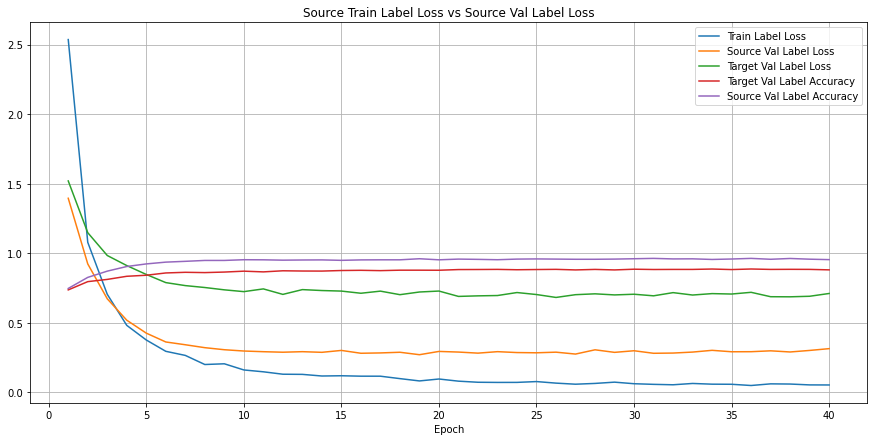

In [16]:
ax = get_loss_curve(experiment)
plt.show()

<AxesSubplot:title={'center':'Results'}>

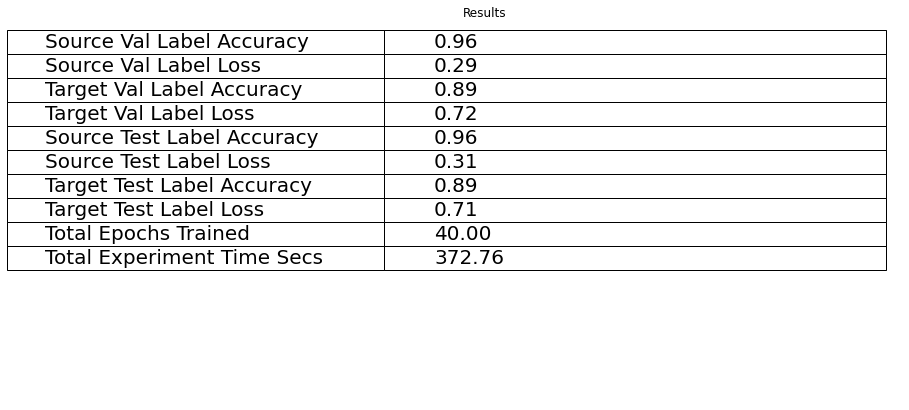

In [17]:
get_results_table(experiment)

<AxesSubplot:title={'center':'Per Domain Validation Accuracy'}, xlabel='domain'>

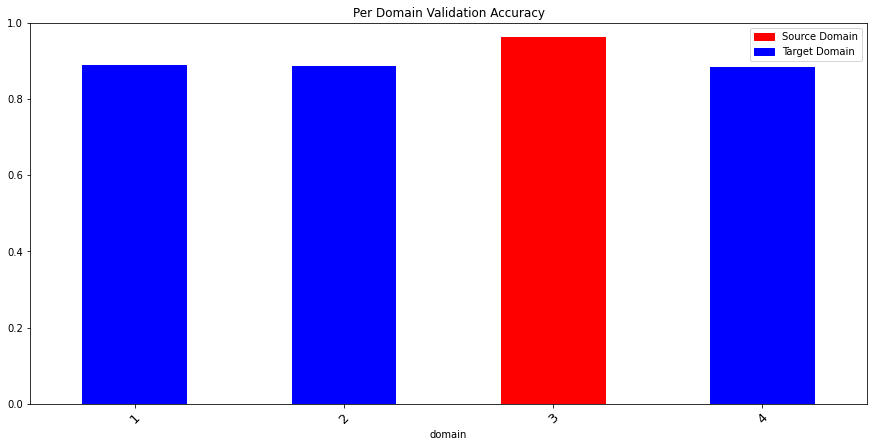

In [18]:
get_domain_accuracies(experiment)

In [19]:
print("Source Test Label Accuracy:", experiment["results"]["source_test_label_accuracy"], "Target Test Label Accuracy:", experiment["results"]["target_test_label_accuracy"])
print("Source Val Label Accuracy:", experiment["results"]["source_val_label_accuracy"], "Target Val Label Accuracy:", experiment["results"]["target_val_label_accuracy"])

Source Test Label Accuracy: 0.9557692307692308 Target Test Label Accuracy: 0.8856837606837606
Source Val Label Accuracy: 0.9634615384615385 Target Val Label Accuracy: 0.8871794871794871


In [20]:
json.dumps(experiment)

'{"experiment_name": "tuned_1v2:wisig", "parameters": {"experiment_name": "tuned_1v2:wisig", "device": "cuda", "lr": 0.0001, "labels_source": ["1-10", "1-12", "1-14", "1-16", "1-18", "1-19", "1-8", "10-11", "10-17", "10-4", "10-7", "11-1", "11-10", "11-19", "11-20", "11-4", "11-7", "12-19", "12-20", "12-7", "13-14", "13-18", "13-19", "13-20", "13-3", "13-7", "14-10", "14-11", "14-12", "14-13", "14-14", "14-19", "14-20", "14-7", "14-8", "14-9", "15-1", "15-19", "15-6", "16-1", "16-16", "16-19", "16-20", "17-10", "17-11", "18-1", "18-10", "18-11", "18-12", "18-13", "18-14", "18-15", "18-16", "18-17", "18-19", "18-2", "18-20", "18-4", "18-5", "18-7", "18-8", "18-9", "19-1", "19-10", "19-11", "19-12", "19-13", "19-14", "19-15", "19-19", "19-2", "19-20", "19-3", "19-4", "19-6", "19-7", "19-8", "19-9", "2-1", "2-13", "2-15", "2-3", "2-4", "2-5", "2-6", "2-7", "2-8", "20-1", "20-12", "20-14", "20-15", "20-16", "20-18", "20-19", "20-20", "20-3", "20-4", "20-5", "20-7", "20-8", "3-1", "3-13", "